# TensorFlow入門１　基本的な仕組み

以下は、TensorFlow version 1.13.1 eigen_py37hbabb2b2_0　にて作動

## 動作確認

In [2]:
import tensorflow as tf

a = tf.constant(5)
b = tf.constant(7)
add = tf.add(a,b)

sess = tf.Session()
output = sess.run(add)
print(output)
sess.close()

12


In [2]:
with tf.Session() as sess:
    output = sess.run(add)
    print(output)

12


## データフロープログラミング

TensorFlowの手順は以下のようになっています。
 - データフローグラフを構築する
 - データを入力して計算する
 
 TensorFlowが値を扱う上で独自の概念として、placeholderとValiableがあります。
 
 ### 《placeholder》
placeholderはデータフローグラフの構築時には値が決まっていないものに使います。最初は配列の形だけ定義しておいて後から値を入れて使う空箱のような存在です。学習ごとに違う値が入る入力データや正解データなどに用いられます。

セッションを実行する際に引数feed_dictを使い、placeholderに入れる値を辞書型で指定します。ここを書き換えることで異なる計算が可能になります。

In [4]:
c = tf.placeholder(tf.int32)
d = tf.placeholder(tf.int32)
add = tf.add(c, d)

sess = tf.Session()
output = sess.run(add, feed_dict={c:5, d:7})
print(output)

12


In [5]:
output = sess.run(add, feed_dict={c:20, d:32})
print(output)

52


### 《Valiable》

Valiableはplaceholderとは違い、データフローグラフの構築時にも値を持ち、更新を行うものに対して使います。学習するパラメータ（重み、バイアス）に用いられます。

### 《constant》
確認になりますが、placeholderでもValiableでもないただの値は定数constantとして扱います。

### 演算

In [6]:
add2 = a+b
output = sess.run(add2)
print(output)

12


In [7]:
kakeru = a * b
output = sess.run(kakeru)
print(output)

35


## セッション終了

In [8]:
sess.close()

# TensorFlow入門２ロジスティック回帰実装

TensorFlowを使いロジスティック回帰を実装していきます。入門1では単純な足し算でしたが、ここでは学習を伴う計算を行います。ANDゲートを題材に学習していく。

In [9]:
#ANDゲート用データの作成
import numpy as np
x_train = np.array([[0,0],[0,1],[1,0],[1,1]])
y_train = np.array([[0],[0],[0],[1]])

## データフローグラフの構築

In [10]:
#placeholderの用意
x = tf.placeholder(tf.float32, [None, 2])
t = tf.placeholder(tf.float32, [None, 1])


第一引数のtf.float32で行列要素の数値のデータ型を指定しています。第二引数の[None,2]で行列の形を指定しています。ここで定義されている2はデータの次元を表しています。Noneの部分はデータ数を表す部分です。任意の数のデータを入れられるように、一般的にNoneを使う。

In [11]:
#valiableの用意
W = tf.Variable(tf.zeros([2,1]))
b = tf.Variable(tf.zeros([1]))

Instructions for updating:
Colocations handled automatically by placer.


tf.Variable()の中でtf.zeros()という関数を呼び出していますが、初期値として0を入れているということ

In [12]:
#ロジスティック回帰の仮定関数と目的関数の定義
y = tf.sigmoid(tf.matmul(x, W) + b)
cross_entropy = tf.reduce_sum(-t * tf.log(y) - (1 - t) * tf.log(1 - y))

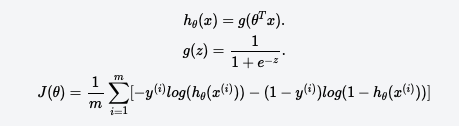

tf.matmul()はNumPyにおけるnp.dot()に相当するベクトルの内積や、行列積を計算するためのメソッドです。なお、例えば回帰問題で二乗和誤差関数を使用するのであれば、tf.reduce_sum(tf.square(y - t))というように定義できます。

ここまでで、入力のための空箱であるplaceholderと学習可能なValiableをメソッドで結ぶことができました。
学習を行うために、勾配降下法を用いてパラメータを最適化するためのコードを加えます。目的関数をGradientDescentOptimizerに渡します。

In [13]:
train_step = tf.train.GradientDescentOptimizer(0.1).minimize(cross_entropy)  #引数は学習率

学習後の結果の正解が正しいかどうかの判定と正解率の計算もデータフローグラフとして定義

In [14]:
correct_prediction = tf.equal(tf.sign(y - 0.5), tf.sign(t -0.5))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

tf.equal()は引数に指定された2つの値が等しいかどうかを判定してくれます。返り値はBool値です。tf.sign()は引数の値が正なら1、0なら0、負なら-1を返します。yが0.5以上かどうかで結果が決まるので、y-0.5とt-0.5の符号を比較しています。
2行目は正解率を計算するためのコードです。tf.reduce_mean()は多次元配列の各成分の平均を計算する関数です。tf.cast()でBool値を0,1に変換しています。つまりここでは正解で1、不正解で0と判定された配列の平均値をとっているので正解率を表していることになります。

## データを入力して計算

In [15]:
#セッションを準備して、パラメータを最適化
sess = tf.Session()
sess.run(tf.global_variables_initializer())

tf.global_variables_initializer()によって上で定義したtf.Variable()の値(重み・バイアス)を初期化

In [16]:
#学習
for epoch in range(1000):
    sess.run(train_step, feed_dict={
        x:x_train,
        t:y_train
    })
    
    if epoch % 100 == 0:
        acc_val = sess.run(
            accuracy, feed_dict={
                x:x_train,
                t:y_train})
        print("epoch: %d, accuracy: %f" %(epoch, acc_val))

epoch: 0, accuracy: 0.750000
epoch: 100, accuracy: 1.000000
epoch: 200, accuracy: 1.000000
epoch: 300, accuracy: 1.000000
epoch: 400, accuracy: 1.000000
epoch: 500, accuracy: 1.000000
epoch: 600, accuracy: 1.000000
epoch: 700, accuracy: 1.000000
epoch: 800, accuracy: 1.000000
epoch: 900, accuracy: 1.000000


In [17]:
#学習結果が正しいか確認

classified = sess.run(correct_prediction, feed_dict={
    x:x_train,
    t:y_train
})

#出力yの確認
prob = sess.run(y, feed_dict={
    x:x_train,
    t:y_train
})

print(classified)
print(prob)

[[ True]
 [ True]
 [ True]
 [ True]]
[[1.9654632e-04]
 [4.9049824e-02]
 [4.9049824e-02]
 [9.3120384e-01]]


In [18]:
print("W:", sess.run(W))
print("b:", sess.run(b))

W: [[5.5699544]
 [5.5699544]]
b: [-8.534579]


### 途中の値が見たい場合（デバッグ）

In [19]:
mat = tf.matmul(x, W)
y = tf.sigmoid(mat + b)
print(sess.run(mat, feed_dict={
    x:x_train,
    t:y_train
}))

[[ 0.       ]
 [ 5.5699544]
 [ 5.5699544]
 [11.139909 ]]


In [20]:
sess.close()

# ディープラーニングフレームワーク１

## 【問題1】スクラッチを振り返る

ディープラーニングを実装するためにはどのようなものが必要だったか

- 活性化関数
- 勾配の算出
- ミニバッチ
- 適切なサンプリング
- 正規化

## 【問題２】スクラッチとTensorFlowの対応を考える

Irisデータセットのversicolorとvirginicaを使用する想定で、以下、TensorFlowのコード


In [1]:
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを2値分類する
"""
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf

# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)
# データフレームから条件抽出
df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# ラベルを数値に変換
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(np.int)[:, np.newaxis]

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 10

n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]      #4
n_samples = X_train.shape[0]  #64
n_classes = 1

In [10]:
# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])    #4
Y = tf.placeholder("float", [None, n_classes]) #64

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """

    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),         #(4, 50)
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),    #(50, 100)
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))      #(100, 1)
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),   #50
        'b2': tf.Variable(tf.random_normal([n_hidden2])),   #100
        'b3': tf.Variable(tf.random_normal([n_classes]))     #1
    }

    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    return layer_output

# ネットワーク構造の読み込み                               
logits = example_net(X)

# 目的関数
loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits))

# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# 推定結果
correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))
# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# variableの初期化
init = tf.global_variables_initializer()


# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)   #サンプル数をバッチで割った値を切り上げ
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            
            #最適化インスタンスを呼び出しして学習
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            
            #ミニバッチで学習したモデルからlossとスコアを計算して加算
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
            
        #全バッチの学習後にサンプル方向に平均取る
        total_loss /= n_samples
        total_acc /= n_samples
        
        #検証データのloss、スコアを取得
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
    
    #全エポック後にテスト
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))

Instructions for updating:
Colocations handled automatically by placer.
Epoch 0, loss : 0.0000, val_loss : 0.5087, acc : 1.000, val_acc : 0.875
Epoch 1, loss : 0.0000, val_loss : 3.1327, acc : 1.000, val_acc : 0.875
Epoch 2, loss : 0.0010, val_loss : 4.0351, acc : 1.000, val_acc : 0.688
Epoch 3, loss : 0.0000, val_loss : 5.0135, acc : 1.000, val_acc : 0.875
Epoch 4, loss : 1.5999, val_loss : 11.4190, acc : 0.750, val_acc : 0.500
Epoch 5, loss : 0.0000, val_loss : 4.1432, acc : 1.000, val_acc : 0.875
Epoch 6, loss : 0.0000, val_loss : 4.3073, acc : 1.000, val_acc : 0.812
Epoch 7, loss : 0.0000, val_loss : 0.2717, acc : 1.000, val_acc : 0.875
Epoch 8, loss : 0.0000, val_loss : 0.0039, acc : 1.000, val_acc : 1.000
Epoch 9, loss : 0.0000, val_loss : 0.0000, acc : 1.000, val_acc : 1.000
test_acc : 0.900


### 考察

- ミニバッチの箇所はスクラッチと同様の処理。唯一の違いはセッションの中に入れる
- 重み、バイアス、活性化関数はネットワーク構造の中で記述


## 【問題３】Iris３種類全てを使用したモデルを作成

https://qiita.com/woowig/items/c6715d3c1557c62ab33a


In [23]:
df3 = pd.read_csv(dataset_path)
y = df3["Species"]
X = df3.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)

# ラベルを数値に変換
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y[y=='Iris-setosa'] = 2

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_one_hot = enc.fit_transform(y[:, np.newaxis])

In [25]:
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_val", X_val.shape)
print("y_val", y_val.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (96, 4)
y_train (96, 3)
X_val (24, 4)
y_val (24, 3)
X_test (30, 4)
y_test (30, 3)


In [32]:
# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 10

n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]      #4
n_samples = X_train.shape[0]  #96
n_classes = 3

In [44]:
# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])    #4
Y = tf.placeholder("float", [None, n_classes]) #3

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """

    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),         #(4, 50)
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),    #(50, 100)
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))      #(100, 3)
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),   #50
        'b2': tf.Variable(tf.random_normal([n_hidden2])),   #100
        'b3': tf.Variable(tf.random_normal([n_classes]))     #3
    }

    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.add(tf.matmul(layer_2, weights['w3']), biases['b3'])
    #layer_output = ft.nn.softmax(layer_3)  TensorFlowの関数で計算するので必要ない
    return layer_output

# ネットワーク構造の読み込み                               
logits = example_net(X)

# 目的関数
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=logits))

# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# 推定結果
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# variableの初期化
init = tf.global_variables_initializer()


# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)   #サンプル数をバッチで割った値を切り上げ
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            
            #最適化インスタンスを呼び出しして学習
            #print(sess.run(logits , feed_dict={X: mini_batch_x, Y: mini_batch_y}))  デバッグ用
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            
            #ミニバッチで学習したモデルからlossとスコアを計算して加算
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
            
        #全バッチの学習後にサンプル方向に平均取る
        total_loss /= n_samples
        total_acc /= n_samples
        
        #検証データのloss、スコアを取得
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
    
    #全エポック後にテスト
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))

Epoch 0, loss : 7.6030, val_loss : 19.7495, acc : 0.833, val_acc : 0.625
Epoch 1, loss : 0.0000, val_loss : 0.3797, acc : 1.000, val_acc : 0.917
Epoch 2, loss : 0.0006, val_loss : 2.7315, acc : 1.000, val_acc : 0.833
Epoch 3, loss : 0.0000, val_loss : 0.9871, acc : 1.000, val_acc : 0.917
Epoch 4, loss : 0.0000, val_loss : 1.4025, acc : 1.000, val_acc : 0.833
Epoch 5, loss : 0.0000, val_loss : 0.7036, acc : 1.000, val_acc : 0.917
Epoch 6, loss : 0.0000, val_loss : 0.9538, acc : 1.000, val_acc : 0.917
Epoch 7, loss : 0.0000, val_loss : 0.4306, acc : 1.000, val_acc : 0.958
Epoch 8, loss : 0.0000, val_loss : 1.7862, acc : 1.000, val_acc : 0.833
Epoch 9, loss : 0.0000, val_loss : 0.4973, acc : 1.000, val_acc : 0.833
test_acc : 0.900


## 【問題４】House Priceのモデルを作成（回帰）

**参考**

https://codeday.me/jp/qa/20190704/1168140.html

https://qiita.com/MahoTakara/items/0d7284774c2adf1f05ec

In [46]:
#データ
df_0 = pd.read_csv('train.csv', index_col=0)
df = df_0.loc[:,["SalePrice", "GrLivArea", "YearBuilt"]]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 3 columns):
SalePrice    1460 non-null int64
GrLivArea    1460 non-null int64
YearBuilt    1460 non-null int64
dtypes: int64(3)
memory usage: 45.6 KB


In [53]:
X = df.iloc[:,[1,2]].values
y = df["SalePrice"].values.reshape(-1,1)

(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.25, random_state=0,)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_val", X_val.shape)
print("y_val", y_val.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (876, 2)
y_train (876, 1)
X_val (219, 2)
y_val (219, 1)
X_test (365, 2)
y_test (365, 1)


In [54]:
# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 10

n_input = X_train.shape[1]      #2
n_samples = X_train.shape[0]  #876
n_classes = 1

In [55]:
# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input], name = "X")    #2
Y = tf.placeholder("float", [None, n_classes], name = "Y") #1

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

# input-to-hidden layer1
W1 = tf.Variable(tf.truncated_normal([n_input,300], stddev = 0.03), name = 'W1')
b1 = tf.Variable(tf.truncated_normal([300]), name = 'b1')  

# hidden layer1-to-output
W2 = tf.Variable(tf.truncated_normal([300,1], stddev = 0.03), name=  'W2')    
b2 = tf.Variable(tf.truncated_normal([1]), name = 'b2')   

# output hidden layer 1
hidden_out = tf.nn.relu(tf.add(tf.matmul(X, W1), b1))   

# total output
y_ = tf.nn.relu(tf.add(tf.matmul(hidden_out, W2), b2)) 

# 目的関数
loss_op = tf.losses.mean_squared_error(Y, y_)

# 最適化手法
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate) 
train_op = optimizer.minimize(loss_op)

# 推定結果
#correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
# 指標値計算
accuracy =  tf.reduce_mean(tf.square(tf.subtract(Y, y_)))

# variableの初期化
init = tf.global_variables_initializer()


# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)   #サンプル数をバッチで割った値を切り上げ
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            
            #最適化インスタンスを呼び出しして学習
            #print(sess.run(logits , feed_dict={X: mini_batch_x, Y: mini_batch_y}))  デバッグ用
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            
            #ミニバッチで学習したモデルからlossとスコアを計算して加算
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
            
        #全バッチの学習後にサンプル方向に平均取る
        total_loss /= n_samples
        total_acc /= n_samples
        
        #検証データのloss、スコアを取得
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
    
    #全エポック後にテスト
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))

Epoch 0, loss : 23090337792.0000, val_loss : 44029878272.0000, acc : 23090337792.000, val_acc : 44029878272.000
Epoch 1, loss : 23090337792.0000, val_loss : 44029878272.0000, acc : 23090337792.000, val_acc : 44029878272.000
Epoch 2, loss : 23090337792.0000, val_loss : 44029878272.0000, acc : 23090337792.000, val_acc : 44029878272.000
Epoch 3, loss : 23090337792.0000, val_loss : 44029878272.0000, acc : 23090337792.000, val_acc : 44029878272.000
Epoch 4, loss : 23090337792.0000, val_loss : 44029878272.0000, acc : 23090337792.000, val_acc : 44029878272.000
Epoch 5, loss : 23090337792.0000, val_loss : 44029878272.0000, acc : 23090337792.000, val_acc : 44029878272.000
Epoch 6, loss : 23090337792.0000, val_loss : 44029878272.0000, acc : 23090337792.000, val_acc : 44029878272.000
Epoch 7, loss : 23090337792.0000, val_loss : 44029878272.0000, acc : 23090337792.000, val_acc : 44029878272.000
Epoch 8, loss : 23090337792.0000, val_loss : 44029878272.0000, acc : 23090337792.000, val_acc : 44029878

## 【問題５】MNISTのモデルを作成

In [70]:
#MNISTデータセット
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#平滑化
X_train_f = X_train.reshape(-1, 784)
X_test_f = X_test.reshape(-1, 784)

#前処理
X_train_ff = X_train_f.astype(np.float)
X_test_ff = X_test_f.astype(np.float)
X_train_ff /= 255
X_test_ff /= 255

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

Xt_train, Xt_val, yt_train, yt_val = train_test_split(X_train_ff, y_train_one_hot, test_size=0.2)
print(Xt_train.shape) # (48000, 784)
print(Xt_val.shape) # (12000, 784)
print(yt_train.shape)
print(yt_val.shape)
print(X_test_ff.shape)
print(y_test_one_hot.shape)

(48000, 784)
(12000, 784)
(48000, 10)
(12000, 10)
(10000, 784)
(10000, 10)


In [71]:
# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 20
num_epochs = 8

n_hidden1 = 200
n_hidden2 = 100
n_input = Xt_train.shape[1]      #784
n_samples = Xt_train.shape[0]  #48000
n_classes = 10

In [72]:
# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])    #4
Y = tf.placeholder("float", [None, n_classes]) #10

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(Xt_train, yt_train, batch_size=batch_size)

def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """

    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),         #(4, 50)
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),    #(50, 100)
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))      #(100, 3)
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),   #50
        'b2': tf.Variable(tf.random_normal([n_hidden2])),   #100
        'b3': tf.Variable(tf.random_normal([n_classes]))     #3
    }

    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.add(tf.matmul(layer_2, weights['w3']), biases['b3'])
    #layer_output = ft.nn.softmax(layer_3)  TensorFlowの関数で計算するので必要ない
    return layer_output

# ネットワーク構造の読み込み                               
logits = example_net(X)

# 目的関数
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=logits))

# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# 推定結果
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# variableの初期化
init = tf.global_variables_initializer()


# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(Xt_train.shape[0]/batch_size).astype(np.int)   #サンプル数をバッチで割った値を切り上げ
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            
            #最適化インスタンスを呼び出しして学習
            #print(sess.run(logits , feed_dict={X: mini_batch_x, Y: mini_batch_y}))  デバッグ用
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            
            #ミニバッチで学習したモデルからlossとスコアを計算して加算
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
            
        #全バッチの学習後にサンプル方向に平均取る
        total_loss /= n_samples
        total_acc /= n_samples
        
        #検証データのloss、スコアを取得
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: Xt_val, Y: yt_val})
        
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
    
    #全エポック後にテスト
    test_acc = sess.run(accuracy, feed_dict={X: X_test_ff, Y: y_test_one_hot})
    print("test_acc : {:.3f}".format(test_acc))

Epoch 0, loss : 0.6016, val_loss : 0.9966, acc : 0.900, val_acc : 0.705
Epoch 1, loss : 1.0624, val_loss : 0.5881, acc : 0.800, val_acc : 0.853
Epoch 2, loss : 0.6716, val_loss : 0.4857, acc : 0.950, val_acc : 0.901
Epoch 3, loss : 0.4260, val_loss : 0.4405, acc : 0.850, val_acc : 0.892
Epoch 4, loss : 0.1005, val_loss : 0.4503, acc : 0.950, val_acc : 0.920
Epoch 5, loss : 0.1012, val_loss : 0.3477, acc : 1.000, val_acc : 0.936
Epoch 6, loss : 0.4846, val_loss : 0.4663, acc : 0.850, val_acc : 0.928
Epoch 7, loss : 0.1115, val_loss : 0.3099, acc : 1.000, val_acc : 0.929
test_acc : 0.929


以上